# Dev [Part 1]

In [1]:
%pylab inline
import sys
from ipywidgets import interact

sys.path.append('src')
from motorControl import *

rc = connect(portName = "/dev/tty.usbserial-A9ETDN3N")

Populating the interactive namespace from numpy and matplotlib


### Initialized Motor Classes

- Really important to initialze these first to restore positions from last session!

In [2]:
#Initialize motor objects for each motor:
vL = Motor(address = 0x81, motorNumber = 2, rc = rc, signFlipped = True, \
           motorCounter = 0, kPID = [1.0, 1.0])
vR = Motor(address = 0x81, motorNumber = 1, rc = rc, signFlipped = True, \
           motorCounter = 1, kPID = [1.0, 1.0])
LR = Motor(address = 0x80, motorNumber = 1, rc = rc, motorCounter = 2, kPID = [1e-2, 1.0])
FB = Motor(address = 0x80, motorNumber = 2, rc = rc, signFlipped = True, \
           motorCounter = 3, kPID = [1.0, 1.0])
yaw = Motor(address = 0x82, motorNumber = 2, rc = rc, signFlipped = False, \
            motorCounter = 4, kPID = [1.0, 1.0])
pitch = Motor(address = 0x82, motorNumber = 1, rc = rc, signFlipped = False, \
              motorCounter = 5, kPID = [1.0, 1.0])

#Keep in a nice motor list:
motors = [vL, vR, LR, FB, yaw, pitch]

In [3]:
getPositions(motors)

[0, 359, 39766, 0, 0, 0]

In [4]:
interact(manualControl, leftUD = (-50, 50), rightUD = (-50, 50), leftRight = (-50, 50), \
         fB = (-50, 50), tilt = (-50, 50), pan = (-50, 50))

<function motorControl.manualControl>

In [5]:
getPositions(motors)

[0, 359, 39766, 0, 0, 0]

In [6]:
LR.getPosition()

39766

In [10]:
targetPosition = LR.getPosition() - 15000.0
timeToReach = 5.0

targetPosition

19633.0

In [11]:
LR.initialize(targetVelocityMin = -2500.0, targetVelocityMax = 2500.0)
LR.clearTracking()

startTime = time.time()
timeElapsed = 0.0

while timeElapsed < timeToReach:
    timeElapsed = time.time()-startTime
    LR.controlledMove(targetPosition = targetPosition, timeToReach = timeToReach-timeElapsed)
    time.sleep(0.1)
v
stopAll(rc)
savePositions(motors)

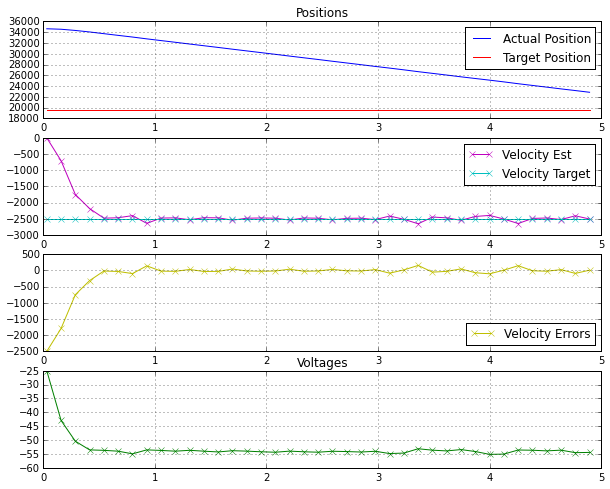

In [12]:
LR.visualizeMove()

Ok, pretty cool! Seems to be working! The next piece of the puzzle here is 1 dimensional trajectory planning. The controller I just wrote will then follow waypoints from my trajectory. Once that is working, I'll wrap up this trajectory planner, we'll call it trajectoryPlannerSimple or something.

In [23]:
startingPosition = LR.getPosition()
targetPosition = startingPosition - 10000.0 #ticks
totalTime = 10.0 #s
numWayPoints = 100

trajectoryTimes = np.linspace(0, totalTime, numWayPoints)

In [63]:
startingPosition

21897

In [66]:
targetPosition

11897.0

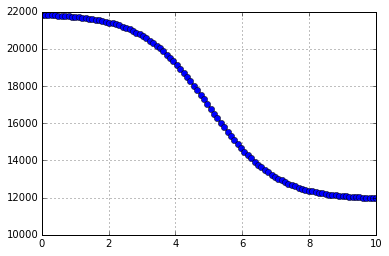

In [62]:
a = (targetPosition-startingPosition); b = 1; c = -1*trajectoryTimes[-1]/2; d = 1
e = startingPosition
trajectory = a/(b+exp(-1*d*(trajectoryTimes + c))) + e

plot(trajectoryTimes, tajectory, 'o-')
grid(1); 

...actually, I think making explicit trajecotry times may be dumb. 

In [168]:
class simpleTrajectory(object):
    def __init__(self, startingPosition, targetPosition, totalTime):
        self.startingPosition = startingPosition
        self.targetPosition = targetPosition
        self.totalTime = totalTime
    
    def compute(self, time):
        a = (self.targetPosition-self.startingPosition); 
        b = 1;
        c = -1*float(self.totalTime)/2.0
        d = 10.0/self.totalTime
        e = self.startingPosition
        
        return float(a)/(1+exp(-1*d*(time + c))) + e
        
    def visualize(self):
        trajectoryTimes = np.linspace(0, self.totalTime, 40)
        trajectory = []
        for time in trajectoryTimes:
            trajectory.append(self.compute(time))

        fig = plt.figure(0, (10, 5))
        plt.plot(trajectoryTimes, trajectory, 'bo')
        plt.grid(1)

In [171]:
startingPosition = LR.getPosition()
targetPosition = startingPosition - 50000.0 #ticks
totalTime = 45.0 #s
lookAheadTime = 1.0 #s

sT = simpleTrajectory(startingPosition, targetPosition, totalTime)

71994 21994.0
71659.3574538 22328.6425462


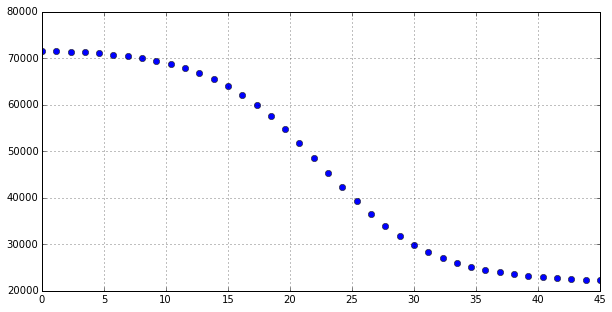

In [172]:
sT.visualize()
print startingPosition, targetPosition
print sT.compute(0), sT.compute(totalTime)

In [125]:
LR.initialize(targetVelocityMin = -2500.0, targetVelocityMax = 2500.0)
LR.clearTracking()

startTime = time.time()
timeElapsed = 0.0

while timeElapsed < totalTime:
    timeElapsed = time.time()-startTime
    lookAheadValue = sT.compute(timeElapsed + lookAheadTime)
    LR.controlledMove(targetPosition = lookAheadValue, timeToReach = lookAheadTime)
    time.sleep(0.1)

stopAll(rc)
savePositions(motors)

In [126]:
stopAll(rc)

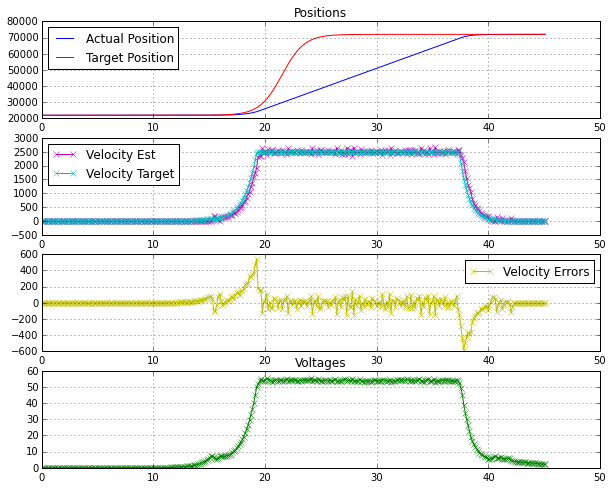

In [127]:
LR.visualizeMove()

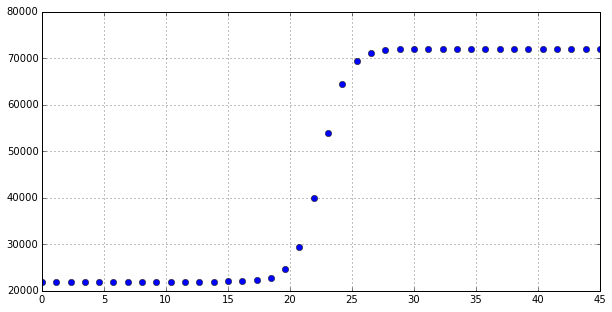

In [129]:
sT.visualize()